# Single-photon Simulation
The following notebook demonstrates the use of the emulator to simulate the propagation of a single photon in a quantum photonic processor. This can be used to find the unitary implemented by a system.

First import required modules and some additional tools.

In [1]:
from collections import Counter

import matplotlib.pyplot as plt

import lightworks as lw
from lightworks import State, emulator

A general N is then defined, which is used to adjust the number of modes used for the circuit throughout the notebook.

In [2]:
N = 8

Can then create a random unitary matrix which is programmed onto the chip.

In [3]:
U = lw.random_unitary(N)

circuit = lw.Unitary(U)

## Simulator
First we try using the simulation part of the emulator. This allows the simulation of a number of input states, finding the probability amplitudes for the given outputs. To set this up, we specify the generated circuit to the simulator class. 

In this case we will choose to try to recreate the unitary matrix, which can be done by creating a list of all single photon input and output states.

In [4]:
# Create all single photon states by adding 1 to list when i=j, otherwise add 0
states = [State([int(i == j) for j in range(N)]) for i in range(N)]

sim = lw.Simulator(circuit, states, states)

# Calculate probability amplitude
backed = emulator.Backend("permanent")
results = backed.run(sim)

U_calc = results.array

The resultant matrix probability amplitude matrix can be visualized below, and we see that the unitary is correctly replicated. Note that the unitary needs to be transposed for the plotting below to show identical matrices.

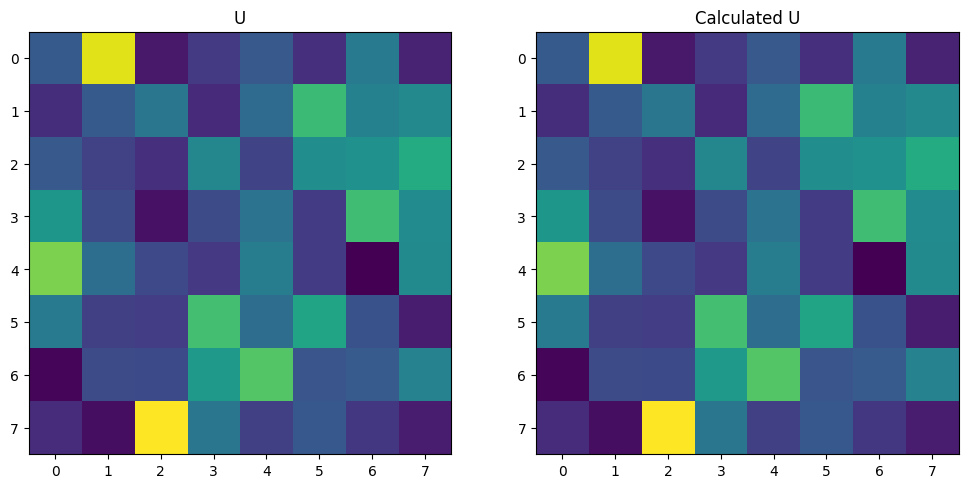

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(abs(U.T))
ax[1].imshow(abs(U_calc))
ax[0].set_title("U")
ax[1].set_title("Calculated U")

plt.show()

It is also possible to directly view the probability amplitudes in a nicer form using the display_as_dataframe function included with the results object. In this case the values are converted to probabilities with the conv_to_probability keyword.

In [6]:
results.display_as_dataframe(conv_to_probability=True)

,"|1,0,0,0,0,0,0,0>","|0,1,0,0,0,0,0,0>","|0,0,1,0,0,0,0,0>","|0,0,0,1,0,0,0,0>","|0,0,0,0,1,0,0,0>","|0,0,0,0,0,1,0,0>","|0,0,0,0,0,0,1,0>","|0,0,0,0,0,0,0,1>"
"|1,0,0,0,0,0,0,0>",0.069378,0.655108,0.007417,0.028719,0.067282,0.021386,0.137687,0.013023
"|0,1,0,0,0,0,0,0>",0.018867,0.069027,0.124257,0.017275,0.101176,0.344731,0.153050,0.171617
"|0,0,1,0,0,0,0,0>",0.066883,0.035832,0.021391,0.167993,0.039286,0.186602,0.198021,0.283992
"|0,0,0,1,0,0,0,0>",0.214553,0.047760,0.005091,0.047379,0.117540,0.029820,0.356083,0.181773
"|0,0,0,0,1,0,0,0>",0.471405,0.106134,0.045029,0.027395,0.139443,0.031223,0.001003,0.178368
"|0,0,0,0,0,1,0,0>",0.138559,0.034179,0.032468,0.366038,0.104098,0.259513,0.056245,0.008900
"|0,0,0,0,0,0,1,0>",0.001931,0.048244,0.046182,0.221076,0.397049,0.060791,0.070994,0.153732
"|0,0,0,0,0,0,0,1>",0.018424,0.003716,0.718166,0.124123,0.034125,0.065934,0.026918,0.008594


## Sampler
Alternatively, the Sampler class can be used to emulate the process of measuring samples from the system. To initialise, this requires the generated circuit, the single input state that we want to look at, and the number of samples to collect. In this case we input a single photon on mode 0.

In [7]:
sampler = lw.Sampler(circuit, State([1] + [0] * (N - 1)), n_samples=100)

Once the sampler has been set up, we can then sample from it many times by running on the backend.

In [8]:
results = backed.run(sampler)

mode_locs = []
for state, count in results.items():
    loc = state.s.index(1)
    mode_locs += [loc] * count

# Count number of times we measure a photon on each mode
counted = Counter(mode_locs)

The counts can then be converted into probabilities and compared to the expected values from the unitary. As we only choose to look at 100 samples here, the measured and expected distributions tend to vary as not enough samples have been taken to see convergence.

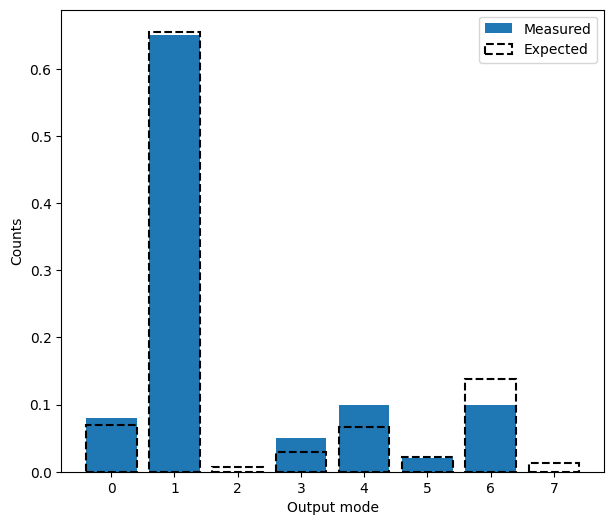

In [9]:
x = range(N)

# Convert counts to a list and normalise to total count numbers
p_calc = [counted[i] / sum(counted.values()) for i in x]

# Find expected distribution
p_exp = abs(U.T[0, :]) ** 2

plt.figure(figsize=(7, 6))
plt.bar(x, p_calc, label="Measured", alpha=1)
plt.bar(
    x,
    p_exp,
    label="Expected",
    edgecolor="Black",
    fill=False,
    linestyle="dashed",
    linewidth=1.5,
)
plt.xlabel("Output mode")
plt.ylabel("Counts")
plt.legend()
plt.show()